In [91]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Missing values

As discussed in the preliminary analysis, there is not any null value in the consumer, merchant and transaction data.

In [92]:
raw_income_df = pd.read_csv("../data/income/2021_income.csv").sort_values('POA_CODE_2021')

In [94]:
income_df = raw_income_df[['POA_CODE_2021', 'Median_tot_prsnl_inc_weekly']].rename(columns={'POA_CODE_2021': 'postcode'})
income_df

,postcode,Median_tot_prsnl_inc_weekly
2579,800,1236
2580,810,1058
2581,812,979
2582,820,1271
2583,822,298
...,...,...
2576,7468,722
2577,7469,503
2578,7470,524
2641,9494,0


In [95]:
income_df[income_df['Median_tot_prsnl_inc_weekly'] == 0]

,postcode,Median_tot_prsnl_inc_weekly
2205,6182,0
2641,9494,0


In [96]:
consumer_df = pd.read_csv('../data/tables/tbl_consumer.csv')

In [105]:
consumer_df[consumer_df['postcode'] == 6182]

,name,address,state,postcode,gender,consumer_id
1171,Christopher Williams,88158 Rogers Mews,WA,6182,Male,710913
1608,Charles Choi,3437 Davis Loop Apt. 339,WA,6182,Male,1373799
2957,Katelyn Huffman,73706 Stephens Centers,WA,6182,Female,395793
3303,Steven Morrison,2423 Walter Square Apt. 390,WA,6182,Male,361676
7005,Larry Roman,30521 Whitney Square,WA,6182,Male,1272657
...,...,...,...,...,...,...
494595,Brandy Frazier,7912 Hopkins Summit Apt. 055,WA,6182,Female,848810
494619,Norma Ryan,0735 Clark Court Apt. 563,WA,6182,Female,1263984
494874,James Olson,2941 Thompson Ridge Suite 663,WA,6182,Male,805630
496992,Dawn Hall,82980 Hawkins Glens Suite 271,WA,6182,Female,993915


In [106]:
consumer_df[consumer_df['postcode'] == 9494]

,name,address,state,postcode,gender,consumer_id


In the income data, the data of areas with postcode 6182 and 9494 is missing. Since no consumer from the consumer dataset lives in the area with postcode 9494, we will ignore this area and impute the weekly personal income for the area with postcode 6182 using the personal family income of two cloest postal areas. 

In [107]:
income_df[income_df['postcode'] >= 6176]

,postcode,Median_tot_prsnl_inc_weekly
2202,6176,895.0
2203,6180,785.0
2204,6181,900.0
2205,6182,842.5
2206,6207,765.0
...,...,...
2576,7468,722.0
2577,7469,503.0
2578,7470,524.0
2641,9494,0.0


In [100]:
# Use average income of the areas with postcode 6180 and 6182 to impute the estimated income for the area with postcode 6182. 
income_df.loc[2205,'Median_tot_prsnl_inc_weekly'] = (785+900)/2
income_df[income_df['postcode'] == 6182]

,postcode,Median_tot_prsnl_inc_weekly
2205,6182,842.5


In [110]:
consumer_with_income = consumer_df.merge(income_df, on='postcode', how='inner')

In [117]:
len(consumer_df),len(consumer_with_income)

(499999, 416818)

As mentioned in the preliminary analysis, since some merchant abns from the transaction data do not match with any merchant from the merchant, we should remove them by inner join with the merchant dataset. About 4% of data are eliminated. (12561377, 12047317)

# Outliers

Since our aim is to rank the merchants, we will remove the outliers with few transactions and low profit.

In [101]:
merchant_detail = pd.read_parquet('../data/curated/merchant_detail.parquet')

In [102]:
merchant_detail

,merchant_name,tags,take_rate,total_income,total_transactions,mean_transaction_amount,monthly_profit
0,Amet Risus Inc.,"([furniture, home furnishings and equipment sh...",6.82,8657277.10,4251,2037.0,32801.0
1,Dignissim Maecenas Foundation,"[[opticians, oPtical goods, and eyeglasses], [...",6.64,8316735.67,58685,142.0,30680.0
2,Orci In Consequat Corporation,"([gift, card, novelty, and souvenir shops], [a...",6.61,8339994.52,75853,110.0,30626.0
3,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...",6.43,8443178.70,241336,35.0,30161.0
4,Etiam Bibendum Industries,"[(tent and awning shops), (a), (take rate: 6.31)]",6.31,8482176.66,6341,1338.0,29735.0
...,...,...,...,...,...,...,...
4021,Feugiat Nec Diam LLC,"([computers, computer peripheral equipment, an...",0.30,18710.78,703,27.0,3.0
4022,Proin Vel Inc.,"[[stationery, office supplies and printing and...",0.16,21967.78,31,709.0,2.0
4023,Hendrerit Donec Limited,"[(digital goods: books, movies, music), (e), (...",0.18,20034.94,590,34.0,2.0
4024,Turpis Incorporated,"[[gift, card, novelty, and souvenir shops], [e...",0.23,16159.06,156,104.0,2.0


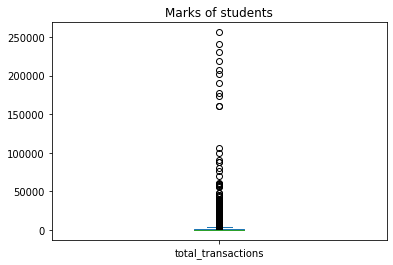

In [118]:
merchant_detail['total_transactions'].plot(kind='box', title='total_transactions')
plt.show()

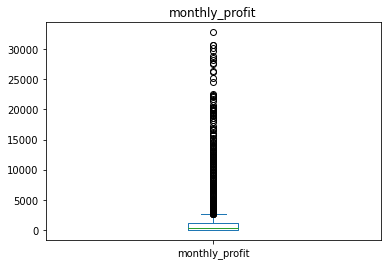

In [119]:
merchant_detail['monthly_profit'].plot(kind='box', title='monthly_profit')
plt.show()

From the boxplot above, we can find that the scale of graph is highly stretched by the extremely large value. But we cannot simply remove these merchants since they might be important in the ranking system. Therefore, we take log transformation for the number of transactions and monthly profit to solve this problem.

In [120]:
merchant_detail['log_transactions_number'] = np.log(merchant_detail['total_transactions'])
merchant_detail['log_monthly_profit'] = np.log(merchant_detail['monthly_profit'])

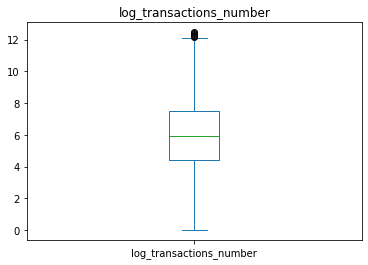

In [122]:
merchant_detail['log_transactions_number'].plot(kind='box', title='log_transactions_number')
plt.show()

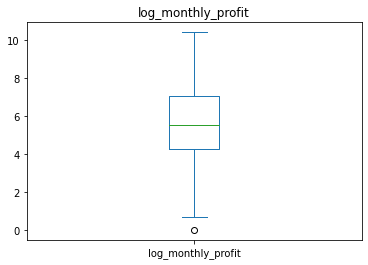

In [123]:
merchant_detail['log_monthly_profit'].plot(kind='box', title='log_monthly_profit')
plt.show()

Now, the boxplot looks much more clear.
Then, we will use Interquartile Range Method to remove the merchants with extreme few transactions or low profit.

In [146]:
def calculate_boundary(columns):
    Q1 = columns.quantile(0.25)
    Q3 = columns.quantile(0.75)
    IQR = Q3-Q1
    return Q1-1*IQR

In [147]:
transactions_boundary = calculate_boundary(merchant_detail['log_transactions_number'])
profit_boundary = calculate_boundary(merchant_detail['log_monthly_profit'])

In [149]:
filtered_merchant_detail1 = merchant_detail[(merchant_detail['log_transactions_number']>=transactions_boundary)]
filtered_merchant_detail2 = filtered_merchant_detail1[(filtered_merchant_detail1['log_monthly_profit']>=profit_boundary)]

In [156]:
np.exp([transactions_boundary, profit_boundary])

array([3.79193884, 4.57546337])

The merchants with number of transactions lower than 4 or with monthly profit lower than 4.575 will be removed. Overall, 1.8% of merchants is removerd.

In [162]:
(len(merchant_detail)-len(filtered_merchant_detail2))/len(merchant_detail)

0.01763537009438649

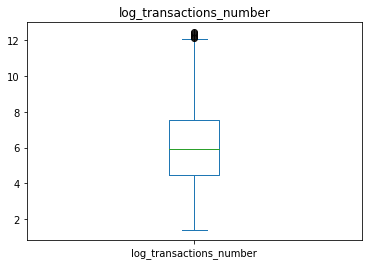

In [163]:
filtered_merchant_detail2['log_transactions_number'].plot(kind='box', title='log_transactions_number')
plt.show()

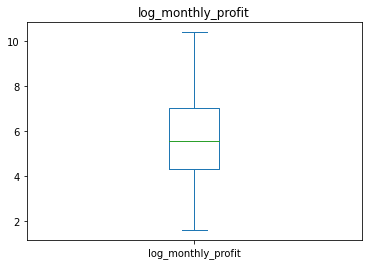

In [164]:
filtered_merchant_detail2['log_monthly_profit'].plot(kind='box', title='log_monthly_profit')
plt.show()

However, the distribution of different types of merchants might be quite different, for example, the number of transactions for the antique merchants is general low but they may be quite profitable. Therefore, we will consider to do the outlier analysis by specific type of merchants in the future. 